In [1]:
import iddefix
import wakis
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
wake = wakis.WakeSolver()
wake.load_results("notebooks/results_fromElle")
wake.solve(
    wakelength=5,
    sigmaz=2e-2,
    skip_cells=5,
    Ez_file="notebooks/results_fromElle/008_Ez.h5",
)

Reading h5 file notebooks/results_fromElle/008_Ez.h5
Calculating longitudinal wake potential WP(s)


100%|██████████| 8482725/8482725 [09:34<00:00, 14772.14it/s] 


Calculating transverse wake potential WPx, WPy...


100%|██████████| 8482725/8482725 [26:41<00:00, 5296.09it/s] 


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


/home/edelafue/wakis/wakis/wakeSolver.py:621: RuntimeWarning: divide by zero encountered in divide
  self.Z = - WPf / lambdaf
/home/edelafue/wakis/wakis/wakeSolver.py:659: RuntimeWarning: divide by zero encountered in divide
  self.Zx = 1j * WPxf / lambdaf
/home/edelafue/wakis/wakis/wakeSolver.py:665: RuntimeWarning: divide by zero encountered in divide
  self.Zy = 1j * WPyf / lambdaf


In [97]:
wake.calc_long_WP(wakelength=5, sigmaz=2e-2)

Calculating longitudinal wake potential WP(s)...


100%|██████████| 292702/292702 [00:00<00:00, 1356403.90it/s]


In [65]:
wake.calc_long_Z(fmax=5e9, samples=1000)

Calculating longitudinal impedance Z...


/tmp/ipykernel_205505/2584506112.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


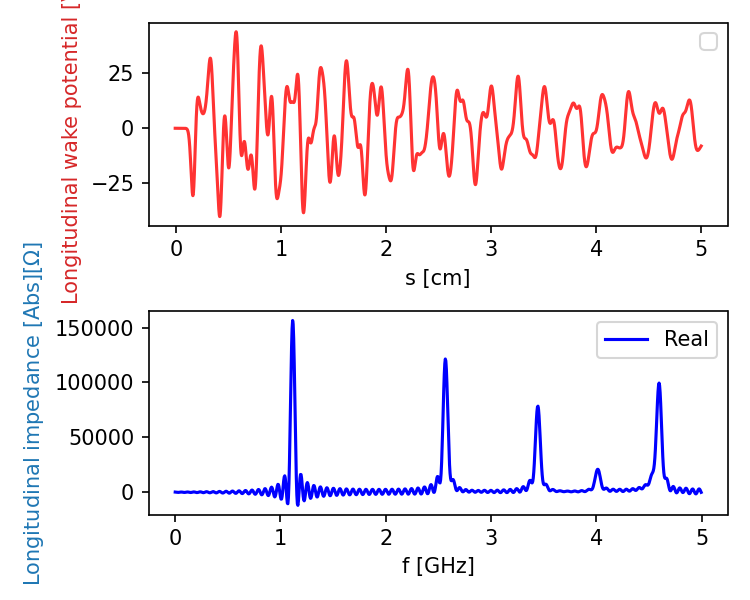

In [67]:
# %matplotlib ipympl
fig1, ax = plt.subplots(2, 1, figsize=[5, 4], dpi=150)

ax[0].plot(wake.s, wake.WP, c="r", alpha=0.8)
ax[0].set_xlabel("s [cm]")
ax[0].set_ylabel("Longitudinal wake potential [V/pC]", color="tab:red")
ax[0].legend()

ax[1].plot(wake.f * 1e-9, np.real(wake.Z), ls="-", c="b", lw=1.5, label="Real")

ax[1].set_xlabel("f [GHz]")
ax[1].set_ylabel("Longitudinal impedance [Abs][$\Omega$]", color="tab:blue")
ax[1].legend()

fig1.tight_layout()

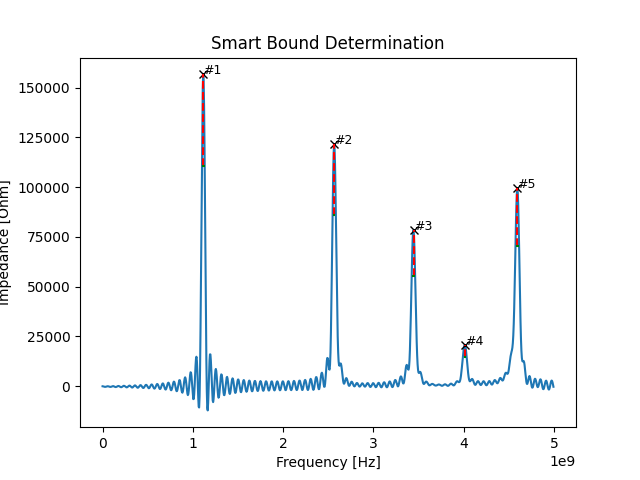


--------------------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |        fres [Hz]        
--------------------------------------------------------------------------------
    1     |125321.00 to 1566512.49 | 18.58 to 185.83  |  1.11e+09 to 1.13e+09   
    2     | 97180.99 to 1214762.34 | 42.75 to 427.50  |  2.56e+09 to 2.58e+09   
    3     | 62689.35 to 783616.89  | 57.42 to 574.17  |  3.44e+09 to 3.46e+09   
    4     | 16514.89 to 206436.06  | 66.92 to 669.17  |  4.01e+09 to 4.03e+09   
    5     | 79573.53 to 994669.12  | 76.58 to 765.83  |  4.59e+09 to 4.61e+09   
--------------------------------------------------------------------------------


In [68]:
heights = np.ones_like(wake.f) * 4e4
heights[np.logical_and(wake.f > 4e9, wake.f < 4.5e9)] = 2e4
bounds = iddefix.SmartBoundDetermination(
    wake.f, wake.Z.real, minimum_peak_height=heights
)
bounds.inspect()
bounds.to_table()

In [69]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(
    wake.f,
    wake.Z.real,
    N_resonators=bounds.N_resonators,
    parameterBounds=bounds.parameterBounds,
    plane="longitudinal",
    fitFunction="impedance",
    wake_length=wake.s[-1],  # in [m]
    objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal,
)

# Run the differential evolution
DE_model.run_differential_evolution(
    maxiter=30000, popsize=150, tol=0.001, mutation=(0.3, 0.8), crossover_rate=0.5
)
print(DE_model.warning)

# OPTIONAL run minimization for fine tuning
DE_model.run_minimization_algorithm(margin=[0.3, 0.2, 0.01])

[!] Using the partially decayed resonator formalism for impedance


Optimization Progress %: 102.32339156534687it [01:19,  1.29it/s]                             




----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.47e+05        |      58.18       |    1.116e+09     
    2     |        1.41e+05        |      68.14       |    2.567e+09     
    3     |        8.94e+04        |      83.70       |    3.444e+09     
    4     |        2.18e+04        |      80.43       |    4.013e+09     
    5     |        1.08e+05        |      93.34       |    4.594e+09     
----------------------------------------------------------------------
callback function requested stop early
Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.46e+05        |      58.1

In [98]:
s = wake.s

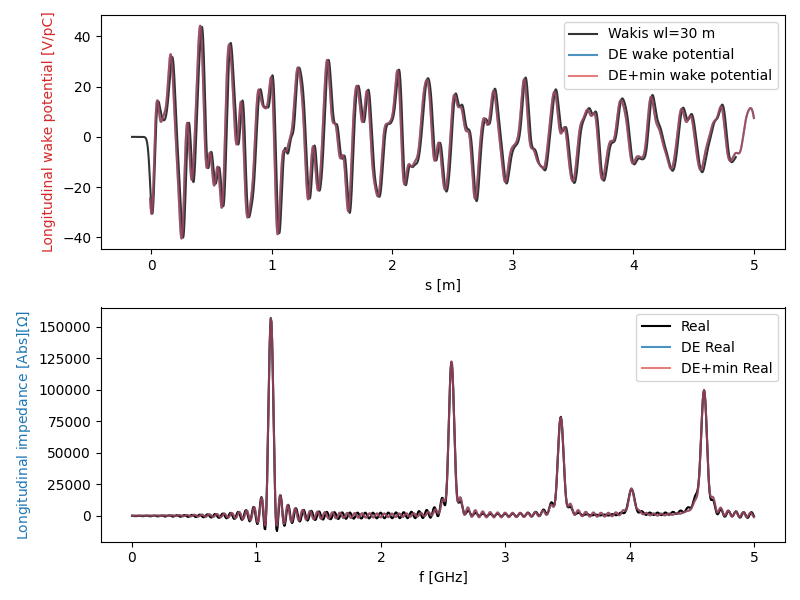

In [110]:
from scipy.constants import c

# Retrieve partially decayed wake potential
WP_pd = DE_model.get_wake_potential(wake.s / c, sigma=2e-2 / c, use_minimization=False)
WP_pd_min = DE_model.get_wake_potential(wake.s / c, sigma=2e-2 / c)

# Retrieve partially decayed impedance
Z_pd = DE_model.get_impedance_from_fitFunction(wake.f, use_minimization=False)
Z_pd_min = DE_model.get_impedance_from_fitFunction(wake.f, use_minimization=True)

fig1, ax = plt.subplots(2, 1, figsize=[8, 6], dpi=100)

ax[0].plot(wake.s - 0.15, wake.WP, c="k", alpha=0.8, label="Wakis wl=30 m")
ax[0].plot(
    wake.s, -WP_pd * 1e-12, c="tab:blue", alpha=0.8, lw=1.5, label="DE wake potential"
)
ax[0].plot(
    wake.s,
    -WP_pd_min * 1e-12,
    c="tab:red",
    alpha=0.6,
    lw=1.5,
    label="DE+min wake potential",
)
ax[0].set_xlabel("s [m]")
ax[0].set_ylabel("Longitudinal wake potential [V/pC]", color="tab:red")
ax[0].legend()

ax[1].plot(wake.f * 1e-9, np.real(wake.Z), ls="-", c="k", lw=1.5, label="Real")
# ax[1].plot(f*1e-9, np.imag(Z), ls=':', c='k', lw=1.5, label='Imag')
# ax[1].plot(f*1e-9, np.real(Z_pd), c='tab:blue', label='Abs')

ax[1].plot(
    wake.f * 1e-9,
    np.real(Z_pd),
    ls="-",
    c="tab:blue",
    alpha=0.8,
    lw=1.5,
    label="DE Real",
)
# ax[1].plot(f_pd*1e-9, np.imag(Z_pd), ls=':', c='tab:blue', alpha=0.6, lw=1.5, label='DE Imag')

ax[1].plot(
    wake.f * 1e-9,
    np.real(Z_pd_min),
    ls="-",
    c="tab:red",
    alpha=0.6,
    lw=1.5,
    label="DE+min Real",
)

ax[1].set_xlabel("f [GHz]")
ax[1].set_ylabel("Longitudinal impedance [Abs][$\Omega$]", color="tab:blue")
ax[1].legend()

fig1.tight_layout()

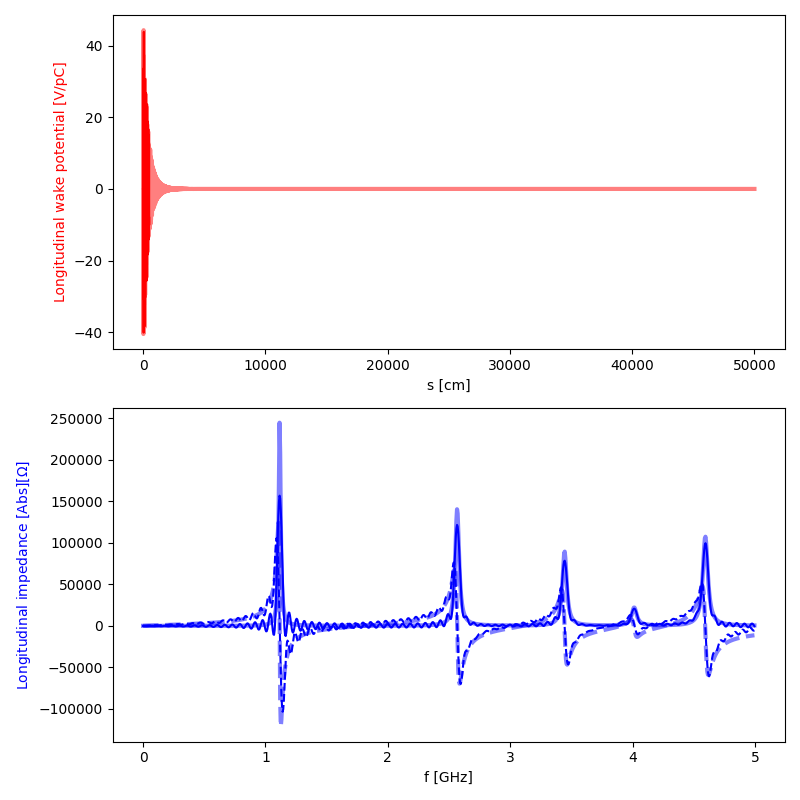

In [109]:
# retrieve the wake potential, function and impedance analytically using the resonator formalism
from scipy.constants import c

sigmaz = 2e-2
new_wakelength = 500  # [m]
s = np.linspace(wake.s[0], new_wakelength, 100000)
wake_potential = DE_model.get_wake_potential(
    s / c, sigma=sigmaz / c, use_minimization=True
)
wake_function = DE_model.get_wake(s / c, use_minimization=True)
impedance = DE_model.get_impedance(wake.f, use_minimization=True)

fig, ax = plt.subplots(2, 1, figsize=[8, 8], dpi=100)
ax[0].plot(wake.s * 1e2, wake.WP, c="r", lw=1.5, label="Wakis")
ax[0].plot(
    s * 1e2,
    -wake_potential * 1e-12,
    c="r",
    lw=3,
    alpha=0.5,
    label="Wakis DE extrapolation",
)
# ax[0].plot(t*c_light*1e2, wake_function/c_light, c='grey', lw=1.5, alpha=0.5, label='Wakis DE extrapolation')
ax[0].set_xlabel("s [cm]")
ax[0].set_ylabel("Longitudinal wake potential [V/pC]", color="r")

ax[1].plot(wake.f * 1e-9, np.real(wake.Z), c="b", lw=1.5, label="Wakis - Re")
ax[1].plot(wake.f * 1e-9, np.imag(wake.Z), c="b", lw=1.5, ls="--", label="Wakis - Imag")

ax[1].plot(
    wake.f * 1e-9, np.real(impedance), c="b", lw=3, alpha=0.5, label="Wakis DE - Re"
)
ax[1].plot(
    wake.f * 1e-9,
    np.imag(impedance),
    c="b",
    lw=3,
    ls="--",
    alpha=0.5,
    label="Wakis DE - Imag",
)
ax[1].set_xlabel("f [GHz]")
ax[1].set_ylabel("Longitudinal impedance [Abs][$\Omega$]", color="b")

fig.tight_layout()